In [1]:
pip install -q git+https://github.com/huggingface/peft.git transformers datasets bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently ta

In [9]:
import os
import pandas as pd
from PIL import Image

# Path to the folder containing the images
tr_image_folder = '/kaggle/input/obss-intern-competition-2025/train/train/'

# Path to the captions file
tr_captions_file = '/kaggle/input/obss-intern-competition-2025/train.csv'

tr_captions_df = pd.read_csv(tr_captions_file)

FILE_EXTENSION = ".jpg"

# Ensure the image paths are correct by converting image_id to string
tr_captions_df['image_path'] = tr_captions_df['image_id'].apply(
    lambda x: os.path.join(tr_image_folder, str(x) + FILE_EXTENSION)
)

tr_captions_df = tr_captions_df.iloc[0:].reset_index(drop=True)

tr_captions_df.head()

,image_id,caption,image_path
0,0,The image features a comic-style panel depicti...,/kaggle/input/obss-intern-competition-2025/tra...
1,1,"Colorful postcard featuring ""Greetings from Ch...",/kaggle/input/obss-intern-competition-2025/tra...
2,2,Two vending machines display a variety of drin...,/kaggle/input/obss-intern-competition-2025/tra...
3,3,A man speaks at the eGovernment Conference 201...,/kaggle/input/obss-intern-competition-2025/tra...
4,4,A close-up of several silver coins stacked tog...,/kaggle/input/obss-intern-competition-2025/tra...


In [10]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and validation (90:10 split)
train_df, valid_df = train_test_split(tr_captions_df, test_size=0.1, random_state=42)

# Check the split
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(valid_df)}")

Training set size: 19230
Test set size: 2137


In [11]:
from torch.utils.data import Dataset
from PIL import Image
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

class ObssDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        caption = self.dataframe.iloc[idx]['caption']
        image = Image.open(image_path).convert('RGB')
        return {"image_id": image, "text": caption}
def collate_fn(batch):
    images = [item["image_id"] for item in batch]
    texts = [item["text"] for item in batch]

    pixel_values = processor(images=images, return_tensors="pt")["pixel_values"]
    text_inputs = processor.tokenizer(texts, padding="longest", return_tensors="pt", truncation=True)

    return {
        "pixel_values": pixel_values,
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"]
    }

In [12]:
from torch.utils.data import DataLoader

train_dataset = ObssDataset(train_df, processor)
valid_dataset = ObssDataset(valid_df, processor)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)

In [13]:
from transformers import Blip2ForConditionalGeneration, Blip2Processor, BitsAndBytesConfig
import torch
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # or 'fp4'
    bnb_4bit_compute_dtype=torch.float16
)

model = Blip2ForConditionalGeneration.from_pretrained(
    "ybelkada/blip2-opt-2.7b-fp16-sharded",
    quantization_config=bnb_config,
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [14]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from peft import TaskType


# Configure LoRA
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        'q_proj', 'v_proj', 'k_proj', 'out_proj', 'fc1', 'fc2', 'language_projection'
    ],  # inspect your model for correct target modules
    lora_dropout=0.05,
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 33,071,104 || all params: 3,777,751,040 || trainable%: 0.8754


In [15]:
import torch
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
device    = "cuda" if torch.cuda.is_available() else "cpu"
model.train()

num_epochs = 1

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:

        input_ids      = batch["input_ids"].to(device)
        pixel_values   = batch["pixel_values"].to(device, torch.float16)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            labels=input_ids
        )

        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} final loss: {loss.item():.4f}")

Epoch 1


Epoch 1:   0%|          | 0/6410 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Epoch 1: 100%|██████████| 6410/6410 [1:29:06<00:00,  1.20it/s, loss=1.47] 

Epoch 1 final loss: 1.4658


In [17]:
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

model.save_pretrained(OUTPUT_DIR)
print(f"PEFT adaptörleri {OUTPUT_DIR} klasörüne kaydedildi.")

PEFT adaptörleri /kaggle/working/ klasörüne kaydedildi.


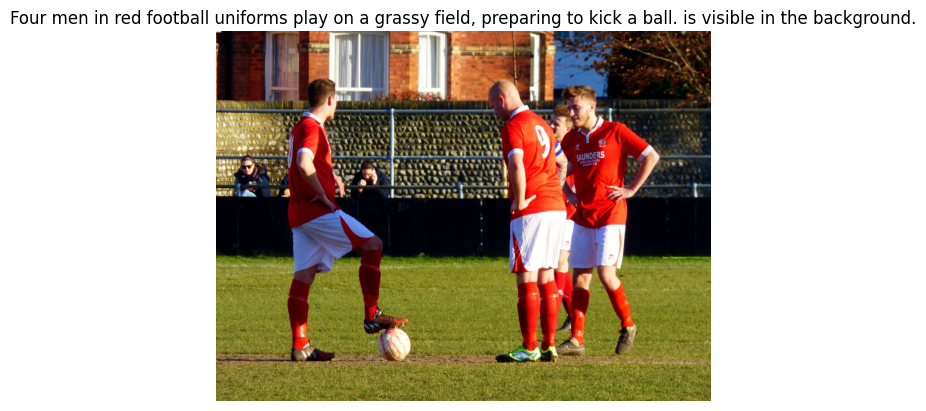

Generated Caption: Four men in red football uniforms play on a grassy field, preparing to kick a ball. is visible in the background.


In [24]:
import matplotlib.pyplot as plt

# Set model to eval mode for inference
model.eval()

# Take one sample from the test set
sample = valid_df.iloc[0]
image_path = sample['image_path']
image = Image.open(image_path).convert("RGB")

# Preprocess image for inference
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

# Generate caption
with torch.no_grad():
    generated_ids = model.generate(
        pixel_values=inputs["pixel_values"],
        max_length=30,
        num_beams=3
    )

# Decode caption
caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Show image with caption
plt.imshow(image)
plt.axis("off")
plt.title(caption, fontsize=12)
plt.show()

# Optional: also print
print(f"Generated Caption: {caption}")

In [25]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

def caption_image(image_input, model, processor, device, max_length=30, num_beams=5,temperature=0.4):
    """
    Generates and displays a caption for the given image.

    Args:
        image_input (str or PIL.Image): Image path or loaded PIL image.
        model: The fine-tuned BLIP-2 model.
        processor: The corresponding processor.
        device: The torch device (e.g., "cuda" or "cpu").
        max_length (int): Maximum length of the generated caption.
        num_beams (int): Beam search width.

    Returns:
        str: Generated caption.
    """
    model.eval()
    
    # Load image if a path is provided
    if isinstance(image_input, str):
        image = Image.open(image_input).convert("RGB")
    else:
        image = image_input.convert("RGB")

    # Preprocess
    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

    # Generate caption
    with torch.no_grad():
        generated_ids = model.generate(
            pixel_values=inputs["pixel_values"],
            max_length=max_length,
            num_beams=num_beams,
            temperature=temperature,
            do_sample=True
        )
    caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Show image with caption
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption, fontsize=12)
    plt.show()

    print(f"Generated Caption: {caption}")
    return caption

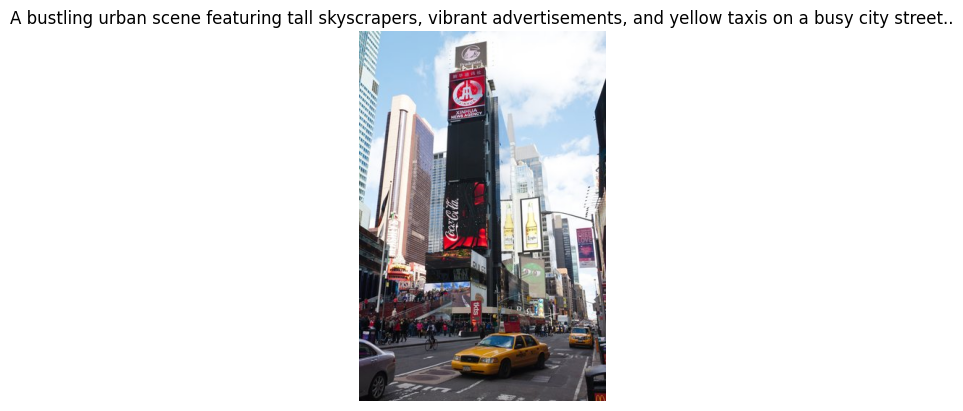

Generated Caption: A bustling urban scene featuring tall skyscrapers, vibrant advertisements, and yellow taxis on a busy city street..


In [26]:
caption = caption_image(valid_df.iloc[5]['image_path'], model, processor, device,temperature=0.8)

In [32]:
# ----- Test Dosyaları ve Yolları -----
test_image_folder = '/kaggle/input/obss-intern-competition-2025/test/test/'
test_csv_file = '/kaggle/input/obss-intern-competition-2025/test.csv'
output_submission_file = '/kaggle/working/submission.csv' # Kaggle'da /kaggle/working/ altına yazmak daha iyidir
FILE_EXTENSION = ".jpg"

# 1. Test veri setini yükle
try:
    test_df = pd.read_csv(test_csv_file)
    print(f"Test CSV dosyası başarıyla yüklendi. Toplam {len(test_df)} resim.")
    # test_df'in 'image_id' sütununu (örn: 100001) içerdiğini varsayıyoruz.
except FileNotFoundError:
    print(f"HATA: Test CSV dosyası bulunamadı: {test_csv_file}")
    raise

Test CSV dosyası başarıyla yüklendi. Toplam 3771 resim.


In [33]:
# 2. Modelin değerlendirme modunda olduğundan emin olun
model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): Blip2ForConditionalGeneration(
      (vision_model): Blip2VisionModel(
        (embeddings): Blip2VisionEmbeddings(
          (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
        )
        (encoder): Blip2Encoder(
          (layers): ModuleList(
            (0-38): 39 x Blip2EncoderLayer(
              (self_attn): Blip2Attention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear4bit(in_features=1408, out_features=4224, bias=True)
                (projection): Linear4bit(in_features=1408, out_features=1408, bias=True)
              )
              (layer_norm1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
              (mlp): Blip2MLP(
                (activation_fn): GELUActivation()
                (fc1): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=1408, out_features=6144, bias=True)
                  (lora_dropout): ModuleDict(
 

In [34]:
results = []

In [35]:
print("Başlık üretimi başlıyor...")
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Test Resimleri İşleniyor"):
    # row['image_id'] bir int64 (örn: 100001). String'e çevirip uzantı ekliyoruz.
    base_image_id = row['image_id']
    image_id_for_submission_and_filename = str(base_image_id) + FILE_EXTENSION # örn: "100001.jpg"
    
    image_path = os.path.join(test_image_folder, image_id_for_submission_and_filename)

    try:
        image = Image.open(image_path).convert("RGB")

        # Görüntüyü işle
        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs["pixel_values"]
        
        # Model float16 ile çalışıyor
        if hasattr(model, 'dtype') and model.dtype == torch.float16:
             pixel_values = pixel_values.to(torch.float16)
        elif hasattr(model, 'config') and model.config.torch_dtype == torch.float16:
             pixel_values = pixel_values.to(torch.float16)


        # Başlık üret
        with torch.no_grad():
            generated_ids = model.generate(
                pixel_values=pixel_values,
                max_length=30,
                num_beams=5,
                # temperature=0.7, # İsteğe bağlı, daha çeşitli çıktılar için
                # do_sample=True   # İsteğe bağlı
            )
        
        caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        
        # Sonuçlara image_id'yi (uzantılı haliyle) ve başlığı ekle
        results.append({'image_id': image_id_for_submission_and_filename, 'caption': caption})

    except FileNotFoundError:
        print(f"UYARI: Resim bulunamadı: {image_path}. Bu resim için boş başlık atanacak.")
        results.append({'image_id': image_id_for_submission_and_filename, 'caption': "IMAGE_NOT_FOUND"})
    except Exception as e:
        print(f"HATA: {image_id_for_submission_and_filename} işlenirken bir hata oluştu: {e}")
        results.append({'image_id': image_id_for_submission_and_filename, 'caption': "ERROR_GENERATING_CAPTION"})

Başlık üretimi başlıyor...


Test Resimleri İşleniyor: 100%|██████████| 3771/3771 [3:33:20<00:00,  3.39s/it]  


In [36]:
submission_df = pd.DataFrame(results)

In [37]:
submission_df.to_csv(output_submission_file, index=False)
print(f"'{output_submission_file}' dosyası başarıyla oluşturuldu.")
print(submission_df.head())

'/kaggle/working/submission.csv' dosyası başarıyla oluşturuldu.
     image_id                                            caption
0  100000.jpg  The image features a red billboard with the te...
1  100001.jpg  A hand holds a watch, a pen, and a knife on a ...
2  100002.jpg  The image shows a convenience store with shelv...
3  100003.jpg  Two red laptops are displayed: one with a red ...
4  100004.jpg  The image features a framed cross-stitch desig...


In [39]:
input_file_path = '/kaggle/working/submission.csv'
output_file_path = '/kaggle/working/submission_cleaned.csv'

In [40]:
try:
    # CSV dosyasını oku
    df = pd.read_csv(input_file_path)
    print(f"'{input_file_path}' dosyası başarıyla okundu.")

    # 'image_id' kolonunun varlığını kontrol et
    if 'image_id' not in df.columns:
        print(f"HATA: '{input_file_path}' dosyasında 'image_id' kolonu bulunamadı.")
    else:
        print("\n'image_id' kolonunun ilk 5 değeri (işlem öncesi):")
        print(df['image_id'].head())

        # 'image_id' kolonundaki her bir değerden '.jpg' uzantısını kaldır
        df['image_id'] = df['image_id'].astype(str)
        # .jpg'yi boş string ile değiştir
        df['image_id'] = df['image_id'].str.replace('.jpg', '', regex=False)

        print("\n'image_id' kolonunun ilk 5 değeri (işlem sonrası):")
        print(df['image_id'].head())

        # Değiştirilmiş DataFrame'i yeni bir CSV dosyasına kaydet
        # index=False, DataFrame index'inin CSV'ye yazılmasını engeller
        df.to_csv(output_file_path, index=False)
        print(f"\nDeğişiklikler başarıyla '{output_file_path}' dosyasına kaydedildi.")
        print("Bu dosya Kaggle 'Output' bölümünde görünecektir.")

except FileNotFoundError:
    print(f"HATA: '{input_file_path}' dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

'/kaggle/working/submission.csv' dosyası başarıyla okundu.

'image_id' kolonunun ilk 5 değeri (işlem öncesi):
0    100000.jpg
1    100001.jpg
2    100002.jpg
3    100003.jpg
4    100004.jpg
Name: image_id, dtype: object

'image_id' kolonunun ilk 5 değeri (işlem sonrası):
0    100000
1    100001
2    100002
3    100003
4    100004
Name: image_id, dtype: object

Değişiklikler başarıyla '/kaggle/working/submission_cleaned.csv' dosyasına kaydedildi.
Bu dosya Kaggle 'Output' bölümünde görünecektir.
